# Gist  

### 1. Problem
Below I am attempting a differentiable programming solution to what is arguably the oldest and most challenging inverse problem.   
The governing equation of the inverse problem we are interested in is none other than the (inhomogeneous) Hemlholtz Equation:  

$$\begin{equation}
\label{eq:helm}
\nabla^2\Psi(\mathbf{r}) + k^2 \psi(\mathbf{r}) = -i \sigma V(\mathbf{r})\psi(\mathbf{r})
\end{equation}
$$
where $\Psi$ is the wavefield, $V$ is the scattering potential, $k^2$ is the wavevector, and $\sigma$ is an interaction strength (or coupling constant).    
The equation above is generally applicable to all forms of radiation (lasers, x-rays...) as well as matter waves (high-energy electron beams, neutrons, etc...).  
In its most general formulation, $\Psi$ is a vector-valued complex field (i.e. to encode polarization states) or in the case of matter waves $\Psi$ is a 4-d spinor. Here, we will ignore polarization states, etc... s.t. we are dealing with scalar fields:  
$$\Psi: \mathbb{R}^3 \rightarrow \mathbb{C}, \quad V: \mathbb{R}^3 \rightarrow \mathbb{R}$$ 

The inverse problem we want to solve is given some data $D = ||\Psi_\textrm{out}||^2$, we would like to recover $V$ (and $\Psi_\textrm{in}$, most researchers only care about $V$ 🤪).  
Multiple variants of this problem arise in many fields and contexts. For instance, in imaging and sensing this inverse problem is known as object reconstruction (i.e. $V$) and in (diffraction) physics/optics it is known as the phase problem ($\arg(\Psi_\textrm{out})$ is not a measurable quantity). 

### 2. Digression #####
-----
```There is tons of approaches to solve this inverse problem (e.g. holography, tomography,) and some like Gabor and Zernike were awarded Nobel Prizes for their work on this problem ... afterall it is the **original inverse problem!**  
So, why bother finding yet another solution to this problem? well... (spoiler alert!!!🚒) none of the above solutions *actually work* in a general sense!  
And by "work in a general sense" I mean: 
1. Algo: here's the associated algorithm 
2. Data: feed it your data 
3. Solution: out comes out get a pretty good solution. 🎊

In fact, researchers, engineers, and companies have spent decades building instruments (CT scanners, microscopes, lightsources, etc...) to make the reconstruction of V easier (or in some cases, like a microscope, trivial!).   

```
-----

### 3. Paraxial Approximation and the Multi-Slice Algorithm
In what follows we use the paraxial approximation to the inhomogeneous Helmholtz equation:

$$\begin{equation}
\frac{\partial \Psi(\mathbf{r}_\perp)}{\partial z} = \frac{i \lambda}{4 \pi} \nabla_{\perp}^2 \psi(\mathbf{r}_\perp) + i \sigma V(\mathbf{r})\psi(\mathbf{r}_\perp)
\end{equation}
$$


In [1]:
using Plots, LinearAlgebra, Flux, NPZ
using Flux: Optimise
using Zygote
using FFTW

FFTW.set_num_threads(8)

# MSA imports
include("MSA.jl")
using .MSA

gr(html_output_format=:png)

# CUDAnative.device!(3)
# CuArrays.allowscalar(true)

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nl7/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


Plots.GRBackend()

### Utils


In [2]:
mutable struct ForwardModel
    psi::AbstractArray
    potential::AbstractArray
    simParams::MSA.SimulationState
    name::String
end

In [21]:
function fft_shift(x)
    Zygote.nograd() do
        shifted = fftshift(x)
    end
    return shifted
end

function shift_probes(psi_k, k_x, k_y, probe_positions)
    psi_empty = Array{ComplexF32}(undef, (size(psi_k)[1], size(psi_k)[2], length(probe_positions)))
    psi_buff = Zygote.Buffer(psi_empty)
    for (idx, pos) in enumerate(probe_positions)
        x, y = pos
        kr = k_x .* x + k_y .* y
        phase_shift = exp.(2.f0 * pi * im .* kr)
        psi_buff[:,:,idx] = ifft(psi_k .* phase_shift, [1,2])
        psi_buff[:,:,idx] = fftshift(copy(psi_buff[:,:,idx]))
        norm = sqrt(sum(abs2, copy(psi_buff[:,:,idx])))
        psi_buff[:,:,idx] = copy(psi_buff[:,:,idx]) ./ norm
    end
    psi = copy(psi_buff)
    return psi
end

function forward(model::ForwardModel, args)
    amp, k_x, k_y, k_arr, probe_positions = args
    psi_k = amp .* exp.(1.0f0 * im * model.psi)
    probes = shift_probes(psi_k, k_x, k_y, probe_positions)
    psi_out = MSA.multislice(probes, model.potential, k_arr, model.simParams)
    psi2_out = abs2.(psi_out)
    return psi2_out
end

function loss(model::ForwardModel, psi2_trg, psik_trg, args)
    psi2_pred = forward(model, args)
    res = norm(psi2_pred .^ 0.5  .- psi2_trg .^ 0.5 , 2)
    return res
end

function sgd_update!(model::ForwardModel, grads, η = 0.01; verbose=false)
    if verbose 
        @info("Gradients:
            ∂V=$(round.(grads.potential; digits=2))
            ∂ѱ=$(round.(grads.psi; digits=2))")
        @info("before sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
    model.psi .-= η .* grads.psi
    model.potential .-= η .* grads.potential
    
    if verbose
        @info("after sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
end

function comp_plot(psi_out, psi_in, V)
    l = @layout [a b c]
    p1 = heatmap(abs2.(psi_in[:,:,1]) .^ 0.25, aspect_ratio=1, framestyle = :none)
    p2 = heatmap(psi_out[:,:,1] .^ 0.1, aspect_ratio=1, framestyle = :none)
    p3 = heatmap(abs2.(V[:,:,1]), aspect_ratio=1, framestyle = :none, color = :viridis)
    heatmap(p1, p2, p3, layout=l, title=["Psi_in" "Data" "V"], size=(1200,400))
    
end

function grad_plot(grads, psi_k)
    l = @layout [a b]
    p1 = heatmap(angle.(grads.psi[:,:,1]), aspect_ratio=1, framestyle = :none)
    p2 = heatmap(angle.(grads.potential)[:,:,1], aspect_ratio=1, framestyle = :none)
    heatmap(p1, p2, layout=l, title=["arg(Grad_Psi)" "arg(Grad_V)"], size=(800,400))
end
    
function diff_plot(psi_out_pred, psi_out_true;clims=:auto)
    heatmap(abs.(psi_out_pred[:,:,1] .- psi_out_true[:,:,1])./ psi_out_true[:,:,1] .* 100, 
        aspect_ratio=1, framestyle= :none, title="% Difference", clims= clims)
end

diff_plot (generic function with 1 method)

#### Set Simulation Params

In [22]:
soft_aperture = Dict("type" => "soft", 
                     "factor" => 100.0)
hard_aperture = Dict("type" => "hard")
probe = Dict("phase_error" => "spherical", 
             "C1" => 1e2, 
             "C3" => 0, 
             "C5" => 0, 
             "Scherzer" => false)
sigma = 0.1
num_slices = 4
slice_thickness = 1
simParams = MSA.SimulationState(0.05, 128, 5.6, 0.02, soft_aperture, probe, sigma, slice_thickness)
probe_positions = MSA.get_probe_coordinates(simParams; grid_steps=[10,10], fraction=0.5, origin=[0., 0.]);

#### Load V

In [23]:
# load a potential
v_file = npzread("../diffpsi/data/potential_5307.npy")
if simParams.sampling == 128
    crop_top = map(Int, [size(v_file)[1] * (1/4), size(v_file)[2] * (3/4)])
elseif simParams.sampling == 64
    crop_top = map(Int, [size(v_file)[1] * (1/8), size(v_file)[2] * (3/8)])
else
    crop_top = (1, size(v_file)[2]+1)
end
slice = range(crop_top[1], stop=crop_top[2]-1)
v_file = v_file[slice, slice]

V_trg = randn(ComplexF32, (simParams.sampling, simParams.sampling, num_slices)) 
for idx in 1:size(V_trg, 3)
    V_trg[:,:,idx] = im * v_file
end

### Generate Solution by simulating $F$

┌ Info: Initiate Wavefunction and Scattering Potential...
└ @ Main In[24]:2


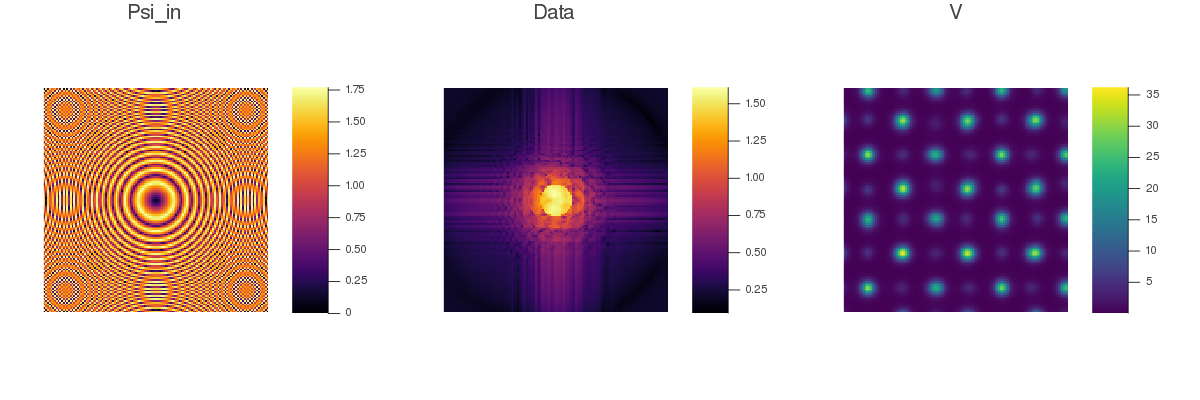

In [24]:
k_size = (simParams.sampling,simParams.sampling)
@info("Initiate Wavefunction and Scattering Potential...") 
psi, psi_k, k_arr = MSA.build_probe(simParams, probe_positions)
psi_trg = psi
cpy_trg = copy(psi_trg)
V_trg = randn(ComplexF32, (k_size..., num_slices)) 
for idx in 1:size(V_trg, 3)
    V_trg[:,:,idx] = v_file
end
MSA.multislice!(psi_trg, V_trg, k_arr, simParams)
psi2_trg = abs2.(psi_trg)
comp_plot(psi2_trg, angle.(psi_k), V_trg)

### Initiate Differentiable Forward Model, $\partial F$

┌ Info: Initiate Forward Model...
└ @ Main In[26]:1


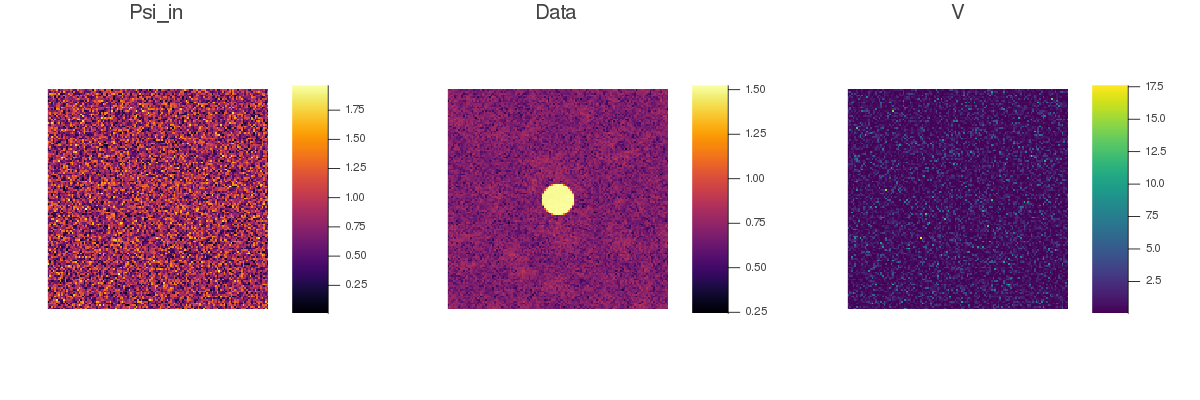

In [26]:
@info("Initiate Forward Model...")
_, psi_k, k_arr = MSA.build_probe(simParams)
k_x, k_y = MSA.get_kspace_coordinates(simParams)
psi_mixing = 0
V_mixing = 0
psi_k_phase = angle.(psi_k) 
psi_in_phase = psi_mixing * psi_k_phase + (1 - psi_mixing) * randn(Float32, size(psi_k))
psi_in_amp = abs.(psi_k) 
V_in = V_mixing * V_trg + (1 - V_mixing) * randn(Float64, size(V_trg))
V_in = V_in .+ 0.0f0 * im
psi_in_phase = psi_in_phase .+ 0.0f0 * im 
args = (psi_in_amp, k_x, k_y, k_arr, probe_positions)
model = ForwardModel(psi_in_phase, V_in, simParams, "∂F")
comp_plot(forward(model, args), psi_in_phase, V_in)

┌ Info: Differentiating Forward Model...
└ @ Main In[27]:2


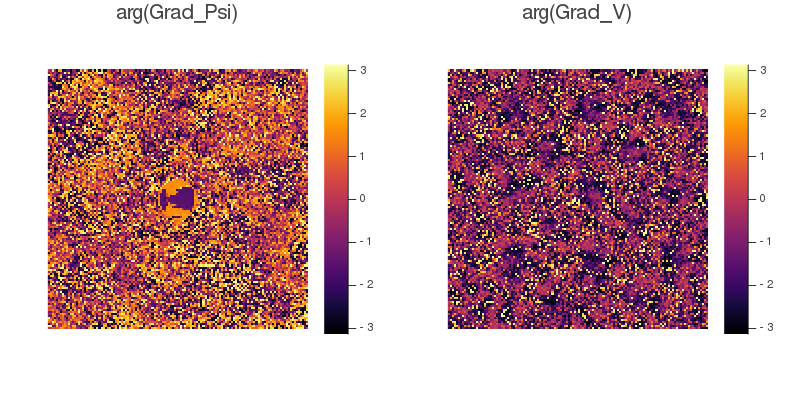

In [27]:
# model gradients
@info("Differentiating Forward Model...")
grads = gradient(model) do m
    return loss(m, psi2_trg, psi_k, args)
end
grads = grads[1][]
grad_plot(grads, psi_k)

### Difference between initial $\partial F$ and solution

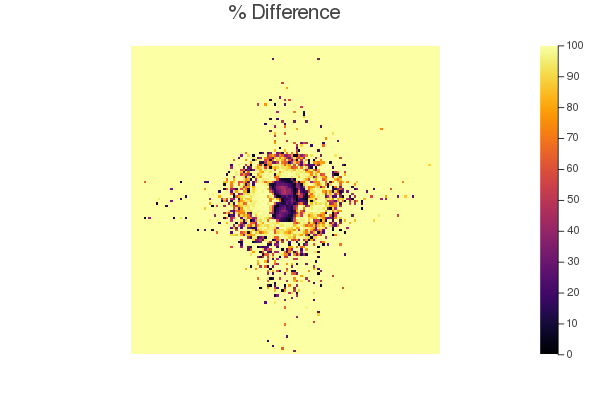

In [28]:
diff_plot(forward(model, args), psi2_trg, clims=(0,100))

### Optimize

In [ ]:
opt = ADAM(1e-1)
ilr = 0.005
opt.eta=ilr
opt.beta=(0.9, 0.99)
@info("Running train loop")
idx = 0
loss_val = loss(model, psi2_trg, psi_k, args)
max_iter = 2e3
num_logs = Int(min(max_iter, 200))
verbose = false
model_hist = Array{Tuple}(undef,num_logs)
loss_hist = Array{Float32}(undef, num_logs)
iter_hist = Array{Int}(undef, num_logs)
hist_idx = 1
@time while idx < max_iter && loss_val > 1e-4
#     lr =  ilr * (idx + 1) .^ (-0.2)
    lr = ilr
    if mod(idx, max_iter ÷ num_logs) == 0
        Zygote.@nograd loss_val = loss(model, psi2_trg, psi_k, args)
        println("lr=$(round(lr;digits=4)), Iteration=$idx, Loss=$(round(loss_val;digits=4))")
        model_hist[hist_idx] = (model.psi[:,:,1], model.potential[:,:,:])
        loss_hist[hist_idx] = loss_val
        iter_hist[hist_idx] = idx
        global hist_idx += 1
    end
    grads= Zygote.gradient(model) do m
        return loss(m, psi2_trg, psi_k, args)
    end
    grads = grads[1][]
#     sgd_update!(model, grads, lr; verbose=false)
    Optimise.update!(opt, model.psi, grads.psi)
    Optimise.update!(opt, model.potential, grads.potential)
    global idx += 1
end

In [ ]:
plot(iter_hist, loss_hist, lw=2, title="Loss vs. # Grad updats", label="Loss")


### Difference between optimized $\partial F$ and solution

In [ ]:
diff_plot(forward(model, args), psi2_trg; clims=(0,100))

### Optimization History of $\bar\Psi_{\textrm{in}}$

In [ ]:
anim = @animate for ((psi,potential), iter) in zip(model_hist[1:hist_idx-1], iter_hist[1:hist_idx-1])
    psi = abs.(psi[:,:,1]) .^ 0.5
#     pot = sum(abs2.(potential), dims=3)[:,:,1]
    pot = sum(abs2.(potential), dims=3)[:,:,1]
    l = @layout [a b]
    p1 = heatmap(psi, aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    p2 = heatmap(pot , aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    heatmap(p1, p2, layout=l, title=["Psi_in\n Iterations=$iter" "V"], size=(800,400))
    end

In [ ]:
gif(anim, "diffProg_kspace.gif", fps=20)

In [ ]:
heatmap(abs.(model.potential)[:,:,1], aspect_ratio=1, framestyle=:none)
# heatmap(abs.(V_in)[:,:,4] .- abs.(model.potential)[:,:,4], aspect_ratio=1, framestyle=:none)

In [340]:
comp_plot(forward(model), model.psi, model.potential)

MethodError: MethodError: no method matching forward(::ForwardModel)
Closest candidates are:
  forward(::ForwardModel, !Matched::Any) at In[327]:20

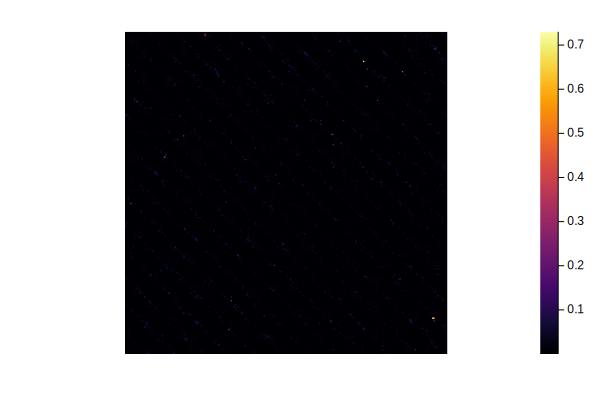

In [25]:
prod_pred = model.psi .* MSA.build_transmPropagator(model.potential[:,:,1],sigma)
heatmap(abs2.(prod_pred)[:,:,1], aspect_ratio=1, framestyle= :none)

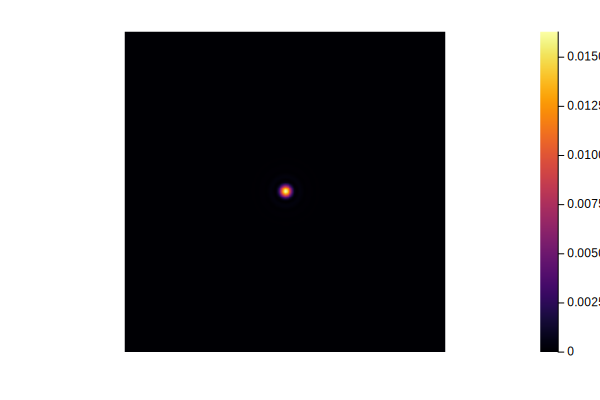

In [26]:
prod_true = psi .* MSA.build_transmPropagator(V_trg[:,:,1],sigma)
heatmap(abs2.(prod_true)[:,:,1], aspect_ratio=1, framestyle= :none)